In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
import pyproj

In [3]:
#carga del dataset
data = gpd.read_file("data_seleccion.csv", encoding='latin1')
data.head(2)

,field_1,place_name,price_usd_per_m2,surface_total_in_m2,lat,lon,floor,rooms,description,title,...,pileta,patio,terraza,lavadero,Belgrano,NuÃ±ez,Palermo,Palermo Hollywood,Recoleta,geometry
0,7,Belgrano,3066.666666666666,45.0,-34.5598729,-58.443362,,,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,...,1,0,1,1,1,0,0,0,0,None
1,8,Belgrano,3000.0,65.0,-34.5598729,-58.443362,,,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",...,1,0,1,1,1,0,0,0,0,None


In [ ]:
#lista con barrios seleccionados
data.groupby('place_name')['place_name'].nunique()


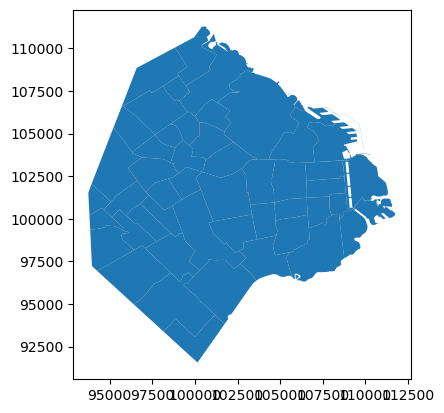

In [4]:
#carga de shapeline
barrios_shp = gpd.read_file("barrios_caba/barrios_censo_2010.shp") 
barrios_shp.plot()

In [5]:
#obtencion de puntos gps de la columna lat y long, a formato geoespacial o geometry
ubicacion_appartments = gpd.points_from_xy(data.lon, data.lat)
ubicacion_appartments

<GeometryArray>
 ...
Length: 4688, dtype: geometry

In [6]:
#incorporación de datos geosatelitales a columna geometry creada por geopandas
data = gpd.GeoDataFrame(data, geometry= ubicacion_appartments)
data.tail()

,field_1,place_name,price_usd_per_m2,surface_total_in_m2,lat,lon,floor,rooms,description,title,...,pileta,patio,terraza,lavadero,Belgrano,NuÃ±ez,Palermo,Palermo Hollywood,Recoleta,geometry
4683,121131,Recoleta,2876.106194690265,113.0,-34.5906282762,-58.397539260900004,,,Excelente semipiso al frente de 4 ambientes. E...,"Venta departamento Recoleta, departamento 3 am...",...,0,0,0,1,0,0,0,0,1,POINT (-58.39754 -34.59063)
4684,121153,Barrio Norte,1813.1868131868127,91.0,-34.5992135511,-58.4025191971,,,EXCELENTE DEPARTAMENTO CON TERRAZA PROPIA Y PA...,EXCELENTE DEPARTAMENTO DE 3 AMBIENTES CON TERR...,...,0,0,1,1,0,0,0,0,0,POINT (-58.40252 -34.59921)
4685,121158,Recoleta,3750.0,44.0,-34.587425443,-58.3973722534,,,Excelente UbicaciÃ³n - Avenida Pueyrredon y La...,Departamento - Recoleta,...,0,0,1,1,0,0,0,0,1,POINT (-58.39737 -34.58743)
4686,121160,Belgrano,2611.464968152867,157.0,-34.563685346,-58.4426825896,,,Edificio en esquina de muy buena categorÃ­a de...,Av .Luis Maria Campos 1400- Belgrano-Capital F...,...,0,0,0,1,1,0,0,0,0,POINT (-58.44268 -34.56369)
4687,121209,Belgrano,2611.464968152867,157.0,-34.563685346,-58.4426825896,,,Edificio en esquina de muy buena categorÃ­a de...,Av .Luis Maria Campos 1400- Belgrano-Capital F...,...,0,0,0,1,1,0,0,0,0,POINT (-58.44268 -34.56369)


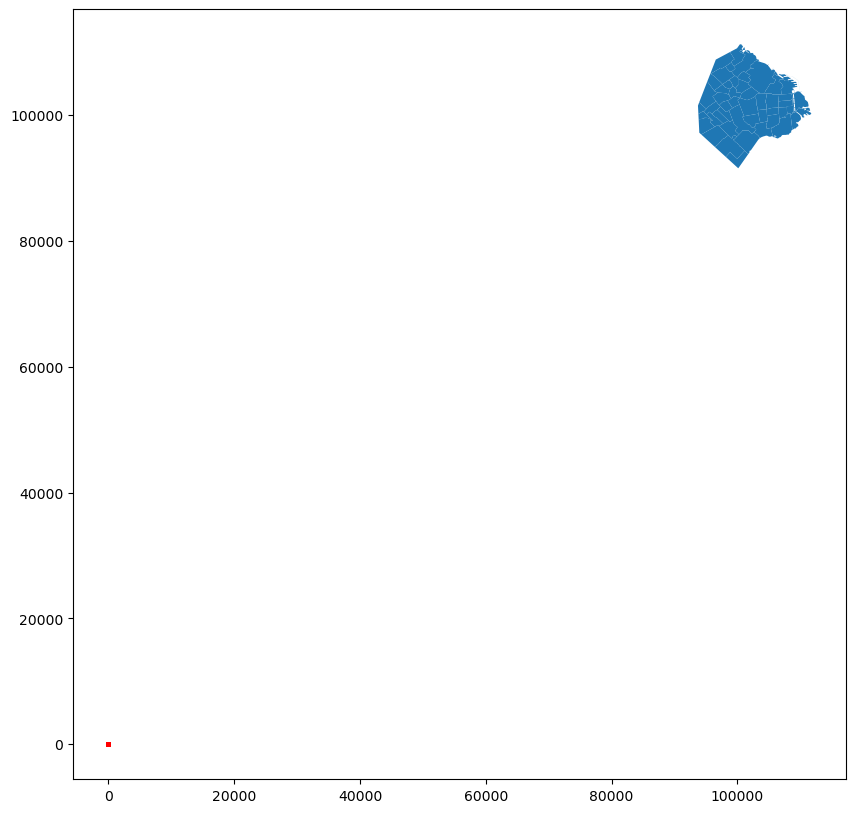

In [10]:
#grafico a proposito para que se vea que no estan en mismo sistema de medición satelital causando que los datos no se alineen correctamente en el gráfico, y comprensión de linea sigte.
fig, ax = plt.subplots(figsize=(10, 10))
barrios_shp.plot(ax=ax)
data.plot(ax=ax, marker='o', color='red', markersize=5)
plt.show()

In [ ]:
from fiona.crs import from_epsg

# Asignar el CRS EPSG:4326
data.crs = from_epsg(4326)



In [ ]:
# verificar el sistema de coordenadas actual
print(barrios_shp.crs)
print(data.crs)

# convertir el sistema de coordenadas de data al mismo que el shapefile
data = data.to_crs(barrios_shp.crs)

# verificar que los sistemas de coordenadas sean iguales
print(barrios_shp.crs == data.crs)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
barrios_shp.plot(ax=ax)
data.plot(ax=ax, marker='o', color='red', markersize=5)
plt.show()